In [1]:
# HIDDEN
from datascience import *
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [2]:
def r_scatter(r):
    plots.figure(figsize=(5,5))
    "Generate a scatter plot with a correlation approximately r"
    x = np.random.normal(0, 1, 1000)
    z = np.random.normal(0, 1, 1000)
    y = r*x + (np.sqrt(1-r**2))*z
    plots.scatter(x, y, color='darkblue', s=20)
    plots.xlim(-4, 4)
    plots.ylim(-4, 4)

## Prediction ##

Let's work with Galton's dataset again.  As a reminder, he looks at a family, and for each child, he measured the average height of the child's two parents, and the height of the child when they reach adulthood.  The former is called the "midparent height" in this notebook.  (Why average height of the two parents?  Well, he was thinking that if the dad was tall or the mom was tall, then their child might be more likely to be tall; and if they were both tall, then that might have an even stronger effect, so the height of both parents is relevant.)  We're going to investigate how well one could predict the future height of a couple's kid, based on the height of the two parents.

In [3]:
galton = Table.read_table('galton.csv')

In [4]:
heights = Table().with_columns(
    'MidParent', galton.column('midparentHeight'),
    'Child', galton.column('childHeight')
    )

In [5]:
heights

MidParent,Child
75.43,73.2
75.43,69.2
75.43,69
75.43,69
73.66,73.5
73.66,72.5
73.66,65.5
73.66,65.5
72.06,71
72.06,68


Recall that often a good thing to do anytime you have a new dataset is to visualize the data.  Let's look at a scatter plot to see if there seems to be any association between midparent height and eventual height of their child.

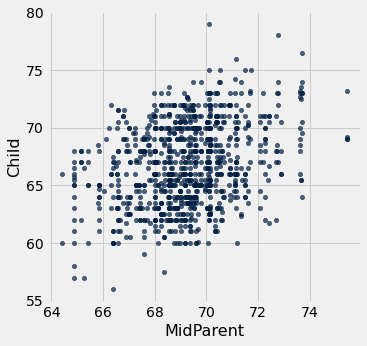

In [6]:
heights.scatter('MidParent')

Looks like there might be a weak association.  Can we use this for prediction?  If we know the height of the two parents, can we predict how tall their kid will be when their kid grows up?  Let's work out how to do that.  The principle is to look for other couples who are similar (in terms of midparent height), where we know how tall their kid turned out to be, and use that to predict.  There might be multiple other couples that are similar, so we'll average the heights of all of their kids.

In [7]:
def predict_child(h):
    """Return a prediction of the height of a child 
    whose parents have a midparent height of h.
    
    The prediction is the average height of the children 
    whose midparent height is in the range h plus or minus 0.5 inches.
    """
    
    close_points = heights.where('MidParent', are.between(h-0.5, h + 0.5))
    return close_points.column('Child').mean()   

In [8]:
heights_with_predictions = heights.with_column(
    'Prediction', heights.apply(predict_child, 'MidParent')
    )

We'll visualize the predictions against this dataset.  Blue dots are the observed data, yellow is the prediction we would have made (with this method).  You can see that the taller the parents are, the taller we predict the child will be.

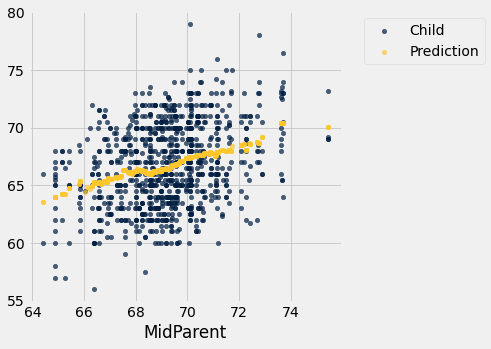

In [9]:
heights_with_predictions.scatter('MidParent')

## Association ##

Let's look at another example. This time we'll look at a dataset of different models of cars, with various attributes for each model of car.  We'll investigate what attributes have an association between them.

In [10]:
hybrid = Table.read_table('hybrid.csv')

In [11]:
hybrid

vehicle,year,msrp,acceleration,mpg,class
Prius (1st Gen),1997,24509.7,7.46,41.26,Compact
Tino,2000,35355,8.2,54.1,Compact
Prius (2nd Gen),2000,26832.2,7.97,45.23,Compact
Insight,2000,18936.4,9.52,53,Two Seater
Civic (1st Gen),2001,25833.4,7.04,47.04,Compact
Insight,2001,19036.7,9.52,53,Two Seater
Insight,2002,19137,9.71,53,Two Seater
Alphard,2003,38084.8,8.33,40.46,Minivan
Insight,2003,19137,9.52,53,Two Seater
Civic,2003,14071.9,8.62,41,Compact


In [12]:
hybrid.sort('msrp', descending=True)

vehicle,year,msrp,acceleration,mpg,class
Lexus LS600h/hL,2007,118544,17.54,21,Midsize
ActiveHybrid 7,2010,104300,20.41,22.11,Large
ActiveHybrid 7i,2011,102606,18.18,20,Midsize
ActiveHybrid X6,2009,97237.9,17.96,18.82,SUV
S400 Long,2009,96208.9,13.89,26.34,Large
Panamera S,2013,96150,18.52,25,Large
Panamera S,2012,95283.9,17.54,25,Large
S400,2013,92350,13.89,21,Large
S400,2010,88212.8,12.99,21,Large
ActiveHybrid 7L,2013,84300,18.18,25,Large


Let's check whether there is an association between miles-per-gallon and the manufacturer's suggested retail price (msrp).

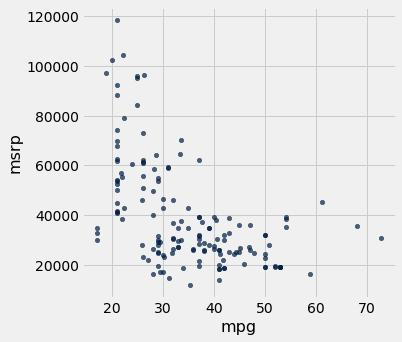

In [13]:
hybrid.scatter('mpg', 'msrp')

Looks like there is some kind of association.  Is it a linear association?  Why do you think there is an association?  On first glance, one might have thought that building a car that gets better miles-per-gallon requires better technology, which would lead to a more expensive car -- but that's not what we're seeing.  Any guesses why?

How about acceleration vs msrp?  Is there an association?  A linear association?  Why?

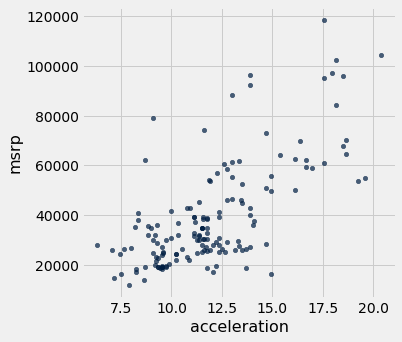

In [14]:
hybrid.scatter('acceleration', 'msrp')

In [15]:
suv = hybrid.where('class', 'SUV')
suv.num_rows

39

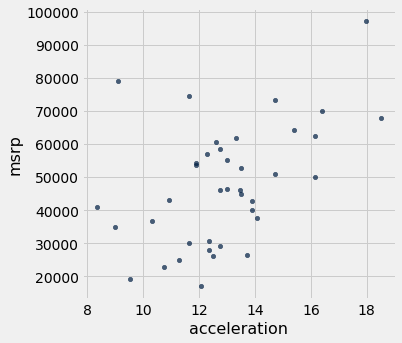

In [16]:
suv.scatter('acceleration', 'msrp')

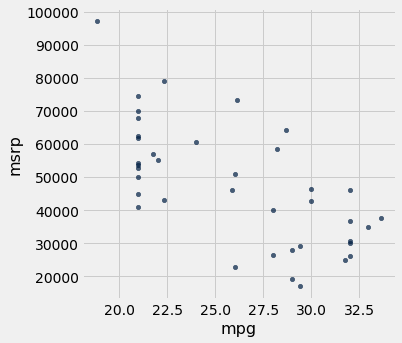

In [17]:
suv.scatter('mpg', 'msrp')

In [18]:
def standard_units(x):
    "Convert any array of numbers to standard units."
    return (x - np.average(x)) / np.std(x)

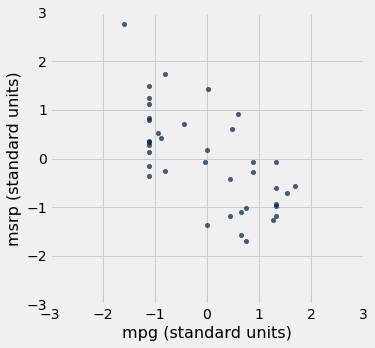

In [19]:
Table().with_columns(
    'mpg (standard units)',  standard_units(suv.column('mpg')), 
    'msrp (standard units)', standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

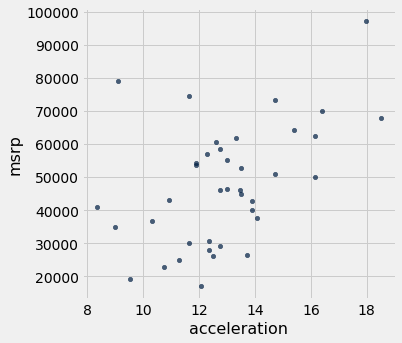

In [20]:
suv.scatter('acceleration', 'msrp')

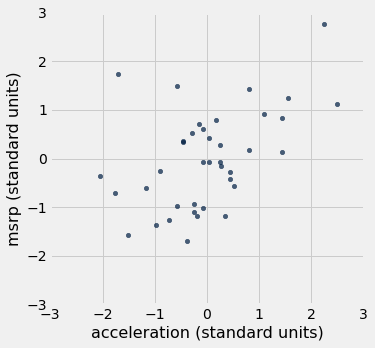

In [21]:
Table().with_columns(
    'acceleration (standard units)', standard_units(suv.column('acceleration')), 
    'msrp (standard units)',         standard_units(suv.column('msrp'))
).scatter(0, 1)
plots.xlim(-3, 3)
plots.ylim(-3, 3);

## Correlation ##

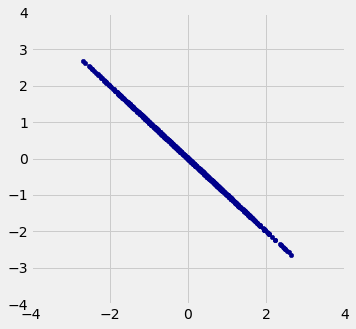

In [22]:
r_scatter(-1)

## Calculating $r$ ##

In [23]:
x = np.arange(1, 7, 1)
y = make_array(2, 3, 1, 5, 2, 7)
t = Table().with_columns(
        'x', x,
        'y', y
    )
t

x,y
1,2
2,3
3,1
4,5
5,2
6,7


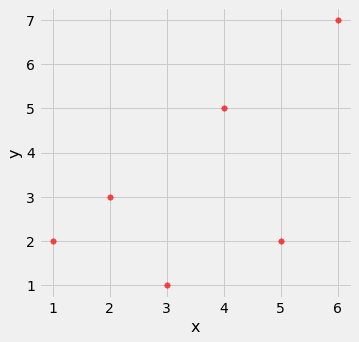

In [24]:
t.scatter('x', 'y', s=30, color='red')

In [25]:
t = t.with_columns(
        'x (standard units)', standard_units(x),
        'y (standard units)', standard_units(y)
    )
t

x,y,x (standard units),y (standard units)
1,2,-1.46385,-0.648886
2,3,-0.87831,-0.162221
3,1,-0.29277,-1.13555
4,5,0.29277,0.811107
5,2,0.87831,-0.648886
6,7,1.46385,1.78444


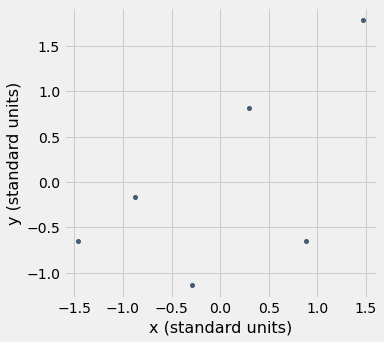

In [26]:
t.scatter(2, 3)

In [27]:
t = t.with_columns('product of standard units', t.column(2) * t.column(3))
t

x,y,x (standard units),y (standard units),product of standard units
1,2,-1.46385,-0.648886,0.949871
2,3,-0.87831,-0.162221,0.142481
3,1,-0.29277,-1.13555,0.332455
4,5,0.29277,0.811107,0.237468
5,2,0.87831,-0.648886,-0.569923
6,7,1.46385,1.78444,2.61215


In [28]:
# r is the average of the products of the standard units

r = np.average(t.column(2) * t.column(3))
r

0.6174163971897709

In [29]:
def correlation(t, x, y):
    """t is a table; x and y are column labels"""
    x_in_standard_units = standard_units(t.column(x))
    y_in_standard_units = standard_units(t.column(y))
    return np.average(x_in_standard_units * y_in_standard_units)

In [30]:
correlation(t, 'x', 'y')

0.6174163971897709

In [31]:
correlation(suv, 'mpg', 'msrp')

-0.6667143635709919

In [32]:
correlation(suv, 'acceleration', 'msrp')

0.48699799279959155

### Switching Axes ###

In [33]:
correlation(t, 'x', 'y')

0.6174163971897709

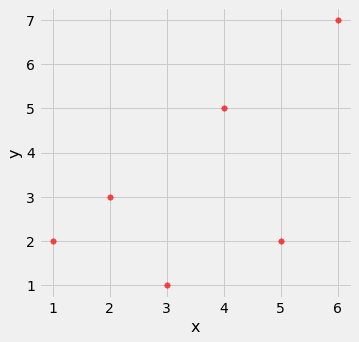

In [34]:
t.scatter('x', 'y', s=30, color='red')

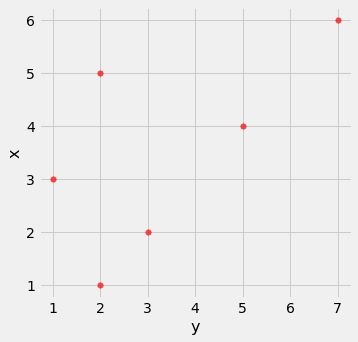

In [35]:
t.scatter('y', 'x', s=30, color='red')

In [36]:
correlation(t, 'y', 'x')

0.6174163971897709

### Nonlinearity ###

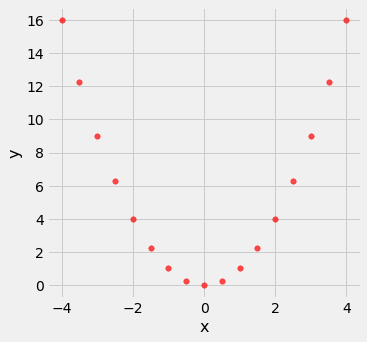

In [37]:
new_x = np.arange(-4, 4.1, 0.5)
nonlinear = Table().with_columns(
        'x', new_x,
        'y', new_x**2
    )
nonlinear.scatter('x', 'y', s=30, color='r')

In [38]:
correlation(nonlinear, 'x', 'y')

0.0

### Outliers ###

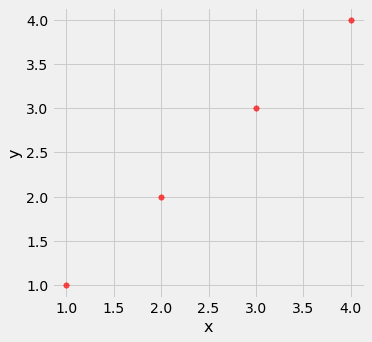

In [39]:
line = Table().with_columns(
        'x', make_array(1, 2, 3, 4),
        'y', make_array(1, 2, 3, 4)
    )
line.scatter('x', 'y', s=30, color='r')

In [40]:
correlation(line, 'x', 'y')

1.0

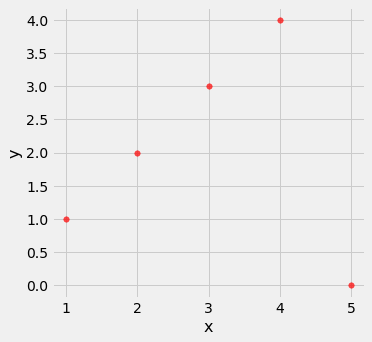

In [41]:
outlier = Table().with_columns(
        'x', make_array(1, 2, 3, 4, 5),
        'y', make_array(1, 2, 3, 4, 0)
    )
outlier.scatter('x', 'y', s=30, color='r')

In [42]:
correlation(outlier, 'x', 'y')

0.0

### Ecological Correlations ###

In [43]:
sat2014 = Table.read_table('sat2014.csv').sort('State')
sat2014

State,Participation Rate,Critical Reading,Math,Writing,Combined
Alabama,6.7,547,538,532,1617
Alaska,54.2,507,503,475,1485
Arizona,36.4,522,525,500,1547
Arkansas,4.2,573,571,554,1698
California,60.3,498,510,496,1504
Colorado,14.3,582,586,567,1735
Connecticut,88.4,507,510,508,1525
Delaware,100,456,459,444,1359
District of Columbia,100,440,438,431,1309
Florida,72.2,491,485,472,1448


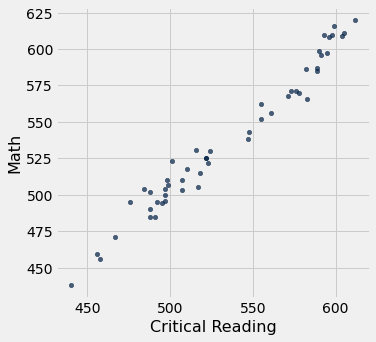

In [44]:
sat2014.scatter('Critical Reading', 'Math')

In [45]:
correlation(sat2014, 'Critical Reading', 'Math')

0.9847558411067434